In [3]:
import pandas as pd
import geopandas as gpd
import numpy as np

from fastdtw import fastdtw

import matplotlib.dates as mdates
from matplotlib.dates import DateFormatter

import matplotlib.pyplot as plt

import rasterio
from osgeo import gdal, ogr, osr
from gdalconst import *
gdal.UseExceptions()

# from datetime import datetime
import datetime as dt

import stac

## Demostração da necessidade da janela móvel

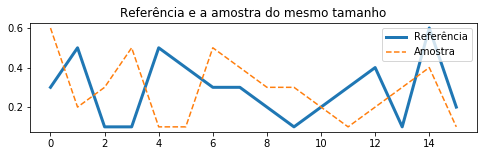

In [2]:
ref =    [0.3, 0.5, 0.1, 0.1, 0.5, 0.4, 0.3, 0.3, 0.2, 0.1, 0.2, 0.3, 0.4, 0.1, 0.6, 0.2]
sample = [0.6, 0.2, 0.3, 0.5, 0.1, 0.1, 0.5, 0.4, 0.3, 0.3, 0.2, 0.1, 0.2, 0.3, 0.4, 0.1]

fig, ax = plt.subplots(1,1, figsize=(8,2))

ax.plot(ref, lw=3, label='Referência')
ax.plot(sample, ls='--', label='Amostra')
ax.legend()
ax.set_title('Referência e a amostra do mesmo tamanho');


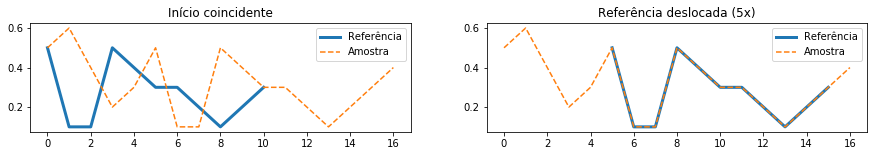

In [3]:
ref =    [0.5, 0.1, 0.1, 0.5, 0.4, 0.3, 0.3, 0.2, 0.1, 0.2, 0.3]
ref_deslocada = np.array([np.nan, np.nan, np.nan, np.nan, np.nan, 0.5, 0.1, 0.1, 0.5, 0.4, 0.3, 0.3, 0.2, 0.1, 0.2, 0.3])
sample = [0.5, 0.6, 0.4, 0.2, 0.3, 0.5, 0.1, 0.1, 0.5, 0.4, 0.3, 0.3, 0.2, 0.1, 0.2, 0.3, 0.4]

fig, ax = plt.subplots(1,2, figsize=(15,2))

ax[0].plot(ref, lw=3, label='Referência')
ax[0].plot(sample, ls='--', label='Amostra')
ax[0].legend()
ax[0].set_title('Início coincidente')

ax[1].plot(ref_deslocada, lw=3, label='Referência')
ax[1].plot(sample, ls='--', label='Amostra')
ax[1].set_title('Referência deslocada (5x)')
ax[1].legend();


#### Janela móvel

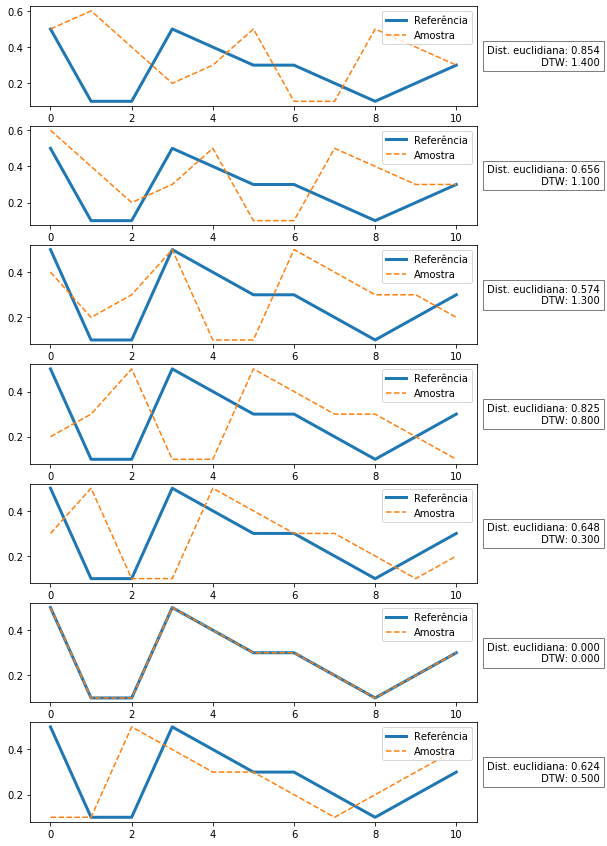

In [4]:
fig, ax = plt.subplots((len(sample)-len(ref)+1), 1, figsize=(8,15))

# Janela móvel de análise
for i in range(len(sample)-len(ref)+1):
    
    sample_part = sample[i:i+len(ref)]
    
    euclidean_distance = np.linalg.norm(np.array(ref) - np.array(sample_part))
    dtw_distance, dtw_path = fastdtw(ref, sample_part)
    text = 'Dist. euclidiana: {:05.3f}'.format(euclidean_distance) + '\n' + '{:>27}'.format('DTW: ' + '{:05.3f}'.format(dtw_distance))
    
    ax[i].plot(ref, label='Referência',lw=3)
    ax[i].plot(sample_part, label='Amostra',ls='--')
    ax[i].text(1.15, 0.5, text, horizontalalignment='center', verticalalignment='center', transform=ax[i].transAxes, bbox=dict(facecolor='white', alpha=0.5))   
    ax[i].legend()

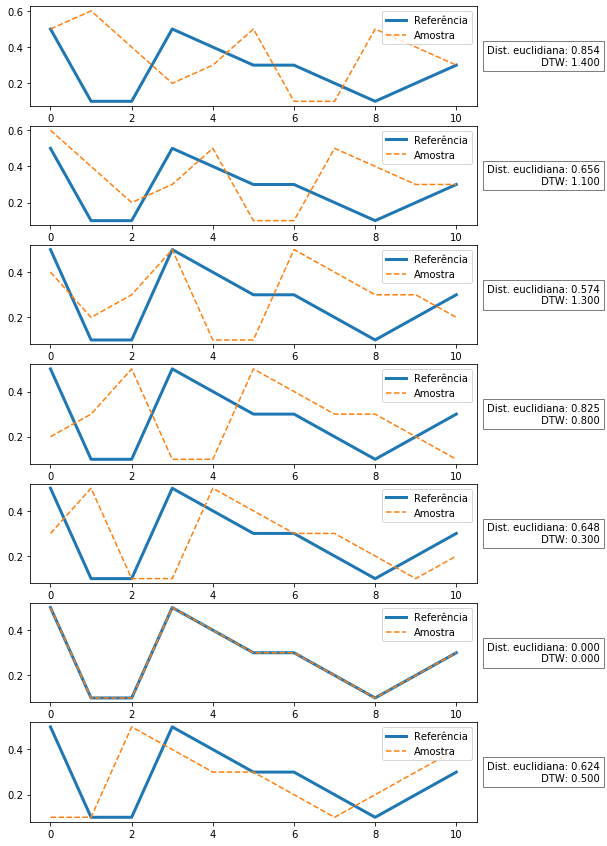

In [6]:
fig, ax = plt.subplots((len(sample)-len(ref)+1), 1, figsize=(8,15))

# Janela móvel de análise
for i in range(len(sample)-len(ref)+1):
    
    sample_part = sample[i:i+len(ref)]
    
    euclidean_distance = np.linalg.norm(np.array(ref) - np.array(sample_part))
    dtw_distance, dtw_path = fastdtw(ref, sample_part)
    text = 'Dist. euclidiana: {:05.3f}'.format(euclidean_distance) + '\n' + '{:>27}'.format('DTW: ' + '{:05.3f}'.format(dtw_distance))
    
    ax[i].plot(ref, label='Referência',lw=3)
    ax[i].plot(sample_part, label='Amostra',ls='--')
    ax[i].text(1.15, 0.5, text, horizontalalignment='center', verticalalignment='center', transform=ax[i].transAxes, bbox=dict(facecolor='white', alpha=0.5))   
    ax[i].legend()

___

## Análise

In [8]:
anos_ag = {'2016':[dt.datetime(2016, 9, 1), dt.datetime(2017, 8, 31)],
           '2017':[dt.datetime(2017, 9, 1), dt.datetime(2018, 8, 31)],
           '2018':[dt.datetime(2018, 9, 1), dt.datetime(2019, 8, 31)],
           '2019':[dt.datetime(2019, 9, 1), dt.datetime(2020, 8, 31)]}

In [9]:
df_interpolado = pd.read_pickle('./DADOS/df_sample_final_sentinel-landsat.pkl').interpolate(method='linear', axis=0).resample('2W').first().interpolate(method='linear', axis=0)
df_interpolado = df_interpolado.T.drop_duplicates().T

dict_values_df = {}

for ano in anos_ag.keys():
    dict_values_df[ano] = df_interpolado.loc[anos_ag[ano][0]:anos_ag[ano][1]]

In [4]:
# Abrir arquivo de referências
references = pd.DataFrame(np.load('./DADOS/df_ref_final.pkl', allow_pickle=True))

# Inserir mais 13 referências observadas visualmente
corte = dt.timedelta(days=45)

col_198 = pd.DataFrame(df_interpolado.loc[anos_ag['2017'][0]:anos_ag['2017'][1],10666])
col_198 = col_198.loc[anos_ag['2017'][0]+corte:anos_ag['2017'][1]-corte,:].reset_index(drop=True)

col_199 = pd.DataFrame(df_interpolado.loc[anos_ag['2017'][0]:anos_ag['2017'][1],5512])
col_199 = col_199.loc[anos_ag['2017'][0]+corte:anos_ag['2017'][1]-corte,:].reset_index(drop=True)

col_200 = pd.DataFrame(df_interpolado.loc[anos_ag['2016'][0]:anos_ag['2016'][1],7998])
col_200 = col_200.loc[anos_ag['2016'][0]+corte:anos_ag['2016'][1]-corte,:].reset_index(drop=True)

col_201 = pd.DataFrame(df_interpolado.loc[anos_ag['2017'][0]:anos_ag['2017'][1],1181])
col_201 = col_201.loc[anos_ag['2017'][0]+corte:anos_ag['2017'][1]-corte,:].reset_index(drop=True)

col_202 = pd.DataFrame(df_interpolado.loc[anos_ag['2016'][0]:anos_ag['2016'][1],6496])
col_202 = col_202.loc[anos_ag['2016'][0]+corte:anos_ag['2016'][1]-corte,:].reset_index(drop=True)

col_203 = pd.DataFrame(df_interpolado.loc[anos_ag['2016'][0]:anos_ag['2016'][1],807])
col_203 = col_203.loc[anos_ag['2016'][0]+corte:anos_ag['2016'][1]-corte,:].reset_index(drop=True)

col_204 = pd.DataFrame(df_interpolado.loc[anos_ag['2016'][0]:anos_ag['2016'][1],3529])
col_204 = col_204.loc[anos_ag['2016'][0]+corte:anos_ag['2016'][1]-corte,:].reset_index(drop=True)

col_205 = pd.DataFrame(df_interpolado.loc[anos_ag['2018'][0]:anos_ag['2018'][1],4400])
col_205 = col_205.loc[anos_ag['2018'][0]+corte:anos_ag['2018'][1]-corte,:].reset_index(drop=True)

col_206 = pd.DataFrame(df_interpolado.loc[anos_ag['2017'][0]:anos_ag['2017'][1],1914])
col_206 = col_206.loc[anos_ag['2017'][0]+corte:anos_ag['2017'][1]-corte,:].reset_index(drop=True)

col_207 = pd.DataFrame(df_interpolado.loc[anos_ag['2018'][0]:anos_ag['2018'][1],3521])
col_207 = col_207.loc[anos_ag['2018'][0]+corte:anos_ag['2018'][1]-corte,:].reset_index(drop=True)

col_208 = pd.DataFrame(df_interpolado.loc[anos_ag['2016'][0]:anos_ag['2016'][1],3521])
col_208 = col_208.loc[anos_ag['2016'][0]+corte:anos_ag['2016'][1]-corte,:].reset_index(drop=True)

col_209 = pd.DataFrame(df_interpolado.loc[anos_ag['2017'][0]:anos_ag['2017'][1],804])
col_209 = col_209.loc[anos_ag['2017'][0]+corte:anos_ag['2017'][1]-corte,:].reset_index(drop=True)


references.insert(loc= 197, column = 198, value = col_198)
references.insert(loc= 198, column = 199, value = col_199)
references.insert(loc= 199, column = 200, value = col_200)
references.insert(loc= 200, column = 201, value = col_201)
references.insert(loc= 201, column = 202, value = col_202)
references.insert(loc= 202, column = 203, value = col_203)
references.insert(loc= 203, column = 204, value = col_204)
references.insert(loc= 204, column = 205, value = col_205)
references.insert(loc= 205, column = 206, value = col_206)
references.insert(loc= 206, column = 207, value = col_207)
references.insert(loc= 207, column = 208, value = col_208)
references.insert(loc= 208, column = 209, value = col_209)

references

,1,2,3,4,5,6,7,8,9,10,...,200,201,202,203,204,205,206,207,208,209
0,0.345400,0.306250,0.289050,0.638350,0.251700,0.608150,0.729000,0.701100,0.440450,0.275150,...,NaN,0.831337,0.880650,0.164600,NaN,0.271293,0.181300,0.837757,0.381200,0.233700
1,0.434300,0.267200,0.320100,0.415800,0.241700,0.564600,0.716500,0.685700,0.286900,0.273100,...,0.296900,0.813250,0.872400,0.159600,NaN,0.666043,0.196350,0.866567,0.425200,0.222471
2,0.525250,0.282400,0.382200,0.277300,0.257000,0.592640,0.716320,0.710183,0.263000,0.397825,...,0.702100,0.824620,0.878600,0.181600,NaN,0.998714,0.187900,0.897877,0.513200,0.209371
3,0.616200,0.410560,0.444300,0.358400,0.425525,0.620680,0.716140,0.734667,0.415925,0.522550,...,0.739300,0.758778,0.884800,0.280380,NaN,0.964600,0.315545,0.700938,0.601200,0.405767
4,0.707150,0.538720,0.506400,0.608150,0.594050,0.648720,0.715960,0.759150,0.568850,0.647275,...,0.776500,0.691956,0.891000,0.379160,NaN,0.930486,0.579818,0.504000,0.689200,0.604033
5,0.798100,0.666880,0.568500,0.857900,0.762575,0.676760,0.715780,0.783633,0.721775,0.772000,...,0.813700,0.613996,0.897200,0.477940,NaN,0.898460,0.811114,0.255960,0.777200,0.816500
6,0.832800,0.795040,0.630600,0.900800,0.931100,0.704800,0.715600,0.808117,0.874700,0.846600,...,0.654900,0.558311,0.903400,0.576720,0.878000,0.917780,0.859686,0.385125,0.865200,0.667667
7,0.858667,0.890300,0.816900,0.916175,0.903900,0.661400,0.788818,0.772200,0.936200,0.842733,...,0.569325,0.575729,0.923833,0.434000,0.797900,0.895400,0.885900,0.680050,0.746300,0.489067
8,0.789644,0.857400,0.892600,0.908800,0.902100,0.664917,0.798236,0.711800,0.926900,0.796800,...,0.510189,0.704533,0.923100,0.192500,0.689600,0.896300,0.900350,0.846700,0.582100,0.310467
9,0.620878,0.526080,0.901257,0.731886,0.837420,0.613367,0.812364,0.769640,0.920180,0.822043,...,0.418356,0.735971,0.904800,0.197300,0.509557,0.766300,0.857267,0.895600,0.469729,0.189000


In [12]:
final_result_euclidian = {}

# Para cada ano agricola
for ano in dict_values_df.keys():
    
    result_points = {}
    
    # Para cada ponto
    for ponto in dict_values_df[ano].columns:
        
        sample = list(dict_values_df[ano].loc[:,ponto])
        
        result = False
        
        # Para cada referencia
        for n in references:
     
            if result:
                break
                
            else:
                ref = list(references[n])
                
                # janela móvel
                i = 0
                while i < len(sample)-len(ref)+1 and not result:

                    sample_part = sample[i:i+len(ref)]

                    euclidean_distance = np.linalg.norm(np.array(ref) - np.array(sample_part))
#                     dtw_distance, dtw_path = fastdtw(ref, sample_part)

                    if euclidean_distance <= 0.68:
                        result = True
                                           
                    i += 1
                    
                
            result_points[ponto] = result
            
        final_result_euclidian[ano] = result_points
        
try:
    pd.DataFrame(final_result_euclidian).to_pickle('./DADOS/df_classif_final_euclidian.pkl')
    print('Salvo!')
except:
    print('Não salvo.')



Salvo!


In [10]:
df = -pd.read_pickle('./DADOS/df_classif_final_euclidian.pkl')
# df = -pd.DataFrame(final_result_euclidian)
# df = df.loc[df.any(axis=1) , : ]
df = -df


In [11]:
df

,2016,2017,2018,2019
1,True,True,True,True
2,True,True,True,True
3,True,True,True,True
4,True,True,True,True
6,True,True,True,True
...,...,...,...,...
11907,True,True,True,True
11909,True,True,True,True
11910,True,True,True,True
11911,True,True,True,True


### Resultado

In [ ]:
from IPython.display import display

pd.options.display.max_rows = 12000
display(df)

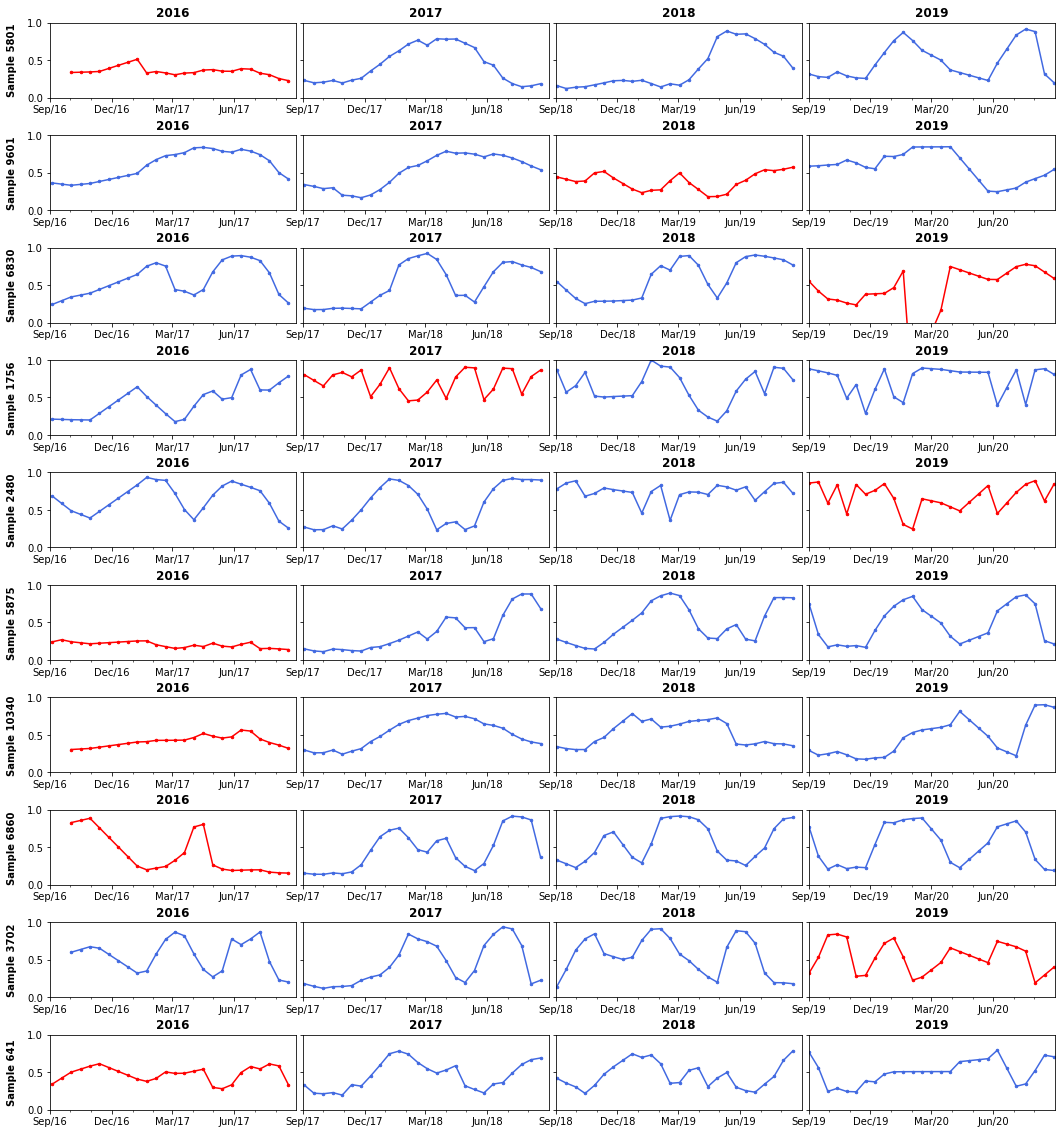

In [32]:

fig, ax = plt.subplots(df.shape[0],len(anos_ag),figsize=(18,20),sharey=True)
fig.subplots_adjust(wspace = .03,hspace=.5)

for linha, ponto in enumerate(df.index):

    for (coluna,ano), intervalo in zip(enumerate(anos_ag),anos_ag.values()):
        
#         if not df.loc[ponto, ano]:
#             cor = 'red'
#         else:
#             cor = 'royalblue'
            
        cor = 'royalblue'    
            
        
        ax[linha,coluna].set_ylim(0,1)

        months = mdates.MonthLocator(interval=3)
        month_fmt = mdates.DateFormatter('%b/%y')
        
        months_minor = mdates.MonthLocator()
        
        ax[linha,coluna].get_xaxis().set_minor_locator(months_minor)
        ax[linha,coluna].get_xaxis().set_major_locator(months)
        ax[linha,coluna].get_xaxis().set_major_formatter(month_fmt)

        ax[linha,coluna].set_title(ano,weight='bold')
        ax[linha,coluna].set_xlim(left=intervalo[0],right=intervalo[1])

        ax[linha,coluna].plot(df_interpolado.loc[intervalo[0]:intervalo[1],ponto],marker='.',ms=5, label='Dado ajustado', color=cor);
#         ax[linha,coluna].plot(df.loc[intervalo[0]:intervalo[1],ponto],lw=.5, color='red', ls='-.', label='Dado bruto');
#         ax[linha,coluna].plot(df_filtrado.loc[intervalo[0]:intervalo[1],ponto],marker='.',lw=0, mec='black', mfc='black', ms=7, label='Valores válidos');

    ax[linha,0].set_ylabel('Sample {}'.format(ponto),labelpad=10,weight='bold');
#     ax[linha,3].legend(bbox_to_anchor=(1.5, .5), loc='center right');


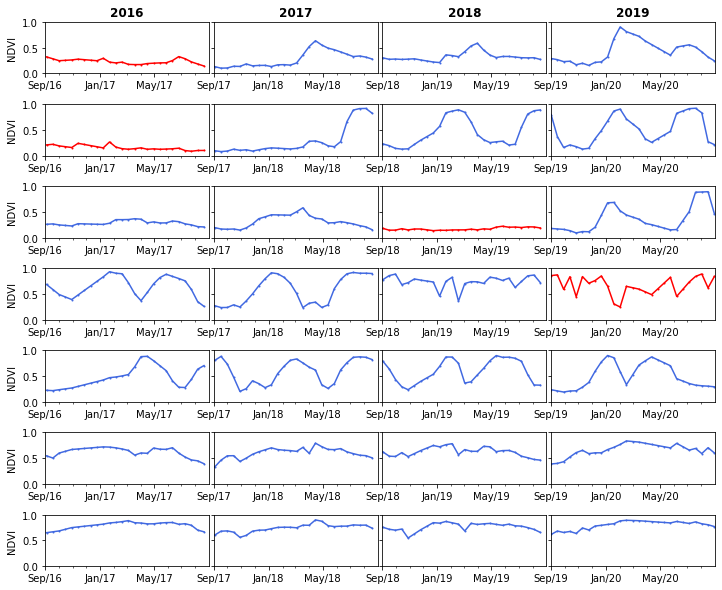

In [19]:
# df = -pd.DataFrame(final_result_euclidian)
# df = df.loc[df.any(axis=1) , : ]
# df = -df

df = df.loc[[10389, 10666, 10691,2480, 1, 6, 7  ],:]
# df = df.loc[[5875,2 ],:]


fig, ax = plt.subplots(df.shape[0],len(anos_ag),figsize=(12,10), sharey=True)
fig.subplots_adjust(wspace = .03,hspace=.6)

for linha, ponto in enumerate(df.index):

    for (coluna,ano), intervalo in zip(enumerate(anos_ag),anos_ag.values()):
        
        if not df.loc[ponto, ano]:
            cor = 'red'
        else:
            cor = 'royalblue'
        
        ax[linha,coluna].set_ylim(0,1)

        months = mdates.MonthLocator(interval=4)
        month_fmt = mdates.DateFormatter('%b/%y')
        
        months_minor = mdates.MonthLocator()
        

        ax[linha,coluna].get_xaxis().set_minor_locator(months_minor)
        ax[linha,coluna].get_xaxis().set_major_locator(months)
        ax[linha,coluna].get_xaxis().set_major_formatter(month_fmt)
        
        if linha == 0:
            ax[linha,coluna].set_title(ano,weight='bold')
        
        ax[linha,coluna].set_xlim(left=intervalo[0],right=intervalo[1])

        ax[linha,coluna].plot(df_interpolado.loc[intervalo[0]:intervalo[1],ponto],marker='.',ms=2, label='Dado ajustado', color=cor);
#         ax[linha,coluna].plot(df.loc[intervalo[0]:intervalo[1],ponto],lw=.5, color='red', ls='-.', label='Dado bruto');
#         ax[linha,coluna].plot(df_filtrado.loc[intervalo[0]:intervalo[1],ponto],marker='.',lw=0, mec='black', mfc='black', ms=7, label='Valores válidos');
    
    ax[linha,0].set_ylabel('NDVI',labelpad=5);
#     ax[linha,0].set_ylabel('Sample {}'.format(ponto),labelpad=10,weight='bold');
#     ax[linha,3].legend(bbox_to_anchor=(1.5, .5), loc='center right');

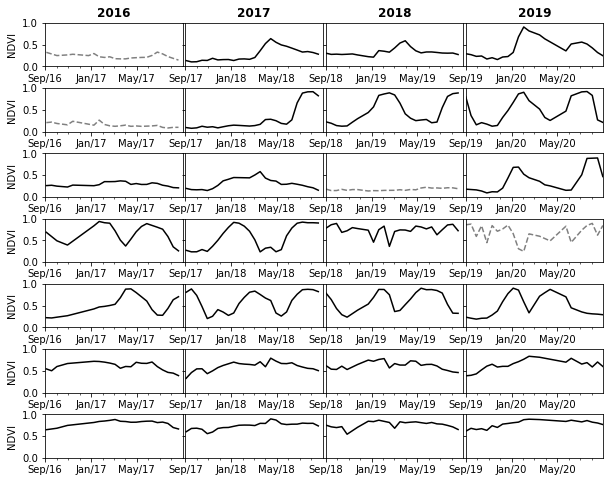

In [13]:
# df = -pd.DataFrame(final_result_euclidian)
# df = df.loc[df.any(axis=1) , : ]
# df = -df

df = df.loc[[10389, 10666, 10691,2480, 1, 6, 7  ],:]
# df = df.loc[[5875,2 ],:]


fig, ax = plt.subplots(df.shape[0],len(anos_ag),figsize=(10,8), sharey=True)
fig.subplots_adjust(wspace = .02,hspace=.5)

for linha, ponto in enumerate(df.index):

    for (coluna,ano), intervalo in zip(enumerate(anos_ag),anos_ag.values()):
        
        if not df.loc[ponto, ano]:
            ls = '--'
            color = 'gray'
        else:
            ls = '-'
            color = 'black'
        
        ax[linha,coluna].set_ylim(0,1)

        months = mdates.MonthLocator(interval=4)
        month_fmt = mdates.DateFormatter('%b/%y')
        
        months_minor = mdates.MonthLocator()
        

        ax[linha,coluna].get_xaxis().set_minor_locator(months_minor)
        ax[linha,coluna].get_xaxis().set_major_locator(months)
        ax[linha,coluna].get_xaxis().set_major_formatter(month_fmt)
        
        if linha == 0:
            ax[linha,coluna].set_title(ano,weight='bold')
        
        ax[linha,coluna].set_xlim(left=intervalo[0],right=intervalo[1])

        ax[linha,coluna].plot(df_interpolado.loc[intervalo[0]:intervalo[1],ponto], color=color, ls=ls);

    
    ax[linha,0].set_ylabel('NDVI',labelpad=5);
#     ax[linha,0].set_ylabel('Sample {}'.format(ponto),labelpad=10,weight='bold');
#     ax[linha,3].legend(bbox_to_anchor=(1.5, .5), loc='center right');

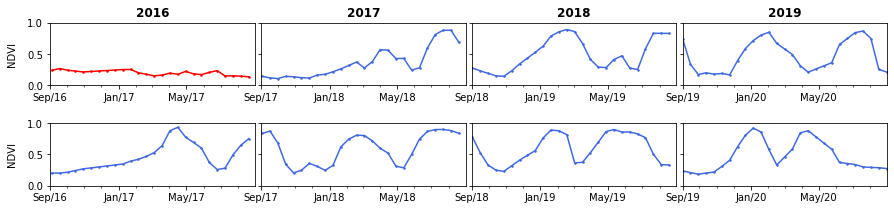

In [22]:
df = -pd.DataFrame(final_result_euclidian)
# df = df.loc[df.any(axis=1) , : ]
df = -df

# df = df.loc[[10389, 10666, 10691,2480, 1, 6, 7  ],:]
df = df.loc[[5875,2 ],:]


fig, ax = plt.subplots(df.shape[0],len(anos_ag),figsize=(15,3), sharey=True)
fig.subplots_adjust(wspace = .03,hspace=.6)

for linha, ponto in enumerate(df.index):

    for (coluna,ano), intervalo in zip(enumerate(anos_ag),anos_ag.values()):
        
        if not df.loc[ponto, ano]:
            cor = 'red'
        else:
            cor = 'royalblue'
            
#         cor = 'gray'
        
        ax[linha,coluna].set_ylim(0,1)

        months = mdates.MonthLocator(interval=4)
        month_fmt = mdates.DateFormatter('%b/%y')
        
        months_minor = mdates.MonthLocator()
        

        ax[linha,coluna].get_xaxis().set_minor_locator(months_minor)
        ax[linha,coluna].get_xaxis().set_major_locator(months)
        ax[linha,coluna].get_xaxis().set_major_formatter(month_fmt)
        
        if linha == 0:
            ax[linha,coluna].set_title(ano,weight='bold')
        
        ax[linha,coluna].set_xlim(left=intervalo[0],right=intervalo[1])

        ax[linha,coluna].plot(df_interpolado.loc[intervalo[0]:intervalo[1],ponto],marker='.',ms=3, label='Dado ajustado', color=cor);
#         ax[linha,coluna].plot(df.loc[intervalo[0]:intervalo[1],ponto],lw=.5, color='red', ls='-.', label='Dado bruto');
#         ax[linha,coluna].plot(df_filtrado.loc[intervalo[0]:intervalo[1],ponto],marker='.',lw=0, mec='black', mfc='black', ms=7, label='Valores válidos');

    ax[linha,0].set_ylabel('NDVI',labelpad=10);
#     ax[linha,3].legend(bbox_to_anchor=(1.5, .5), loc='center right');